# Setup

In [1]:
from __future__ import print_function
import numpy as np
import keras
import keras.datasets.cifar10
from tqdm import trange
import matplotlib.pyplot as plt
np.random.seed(20191220)

2024-06-23 19:40:03.619023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes and Functions

In [2]:
class Layer:
    def __init__(self):
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + bias
        return output

class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self, input, gradient_output):
        gradient_input = np.dot(gradient_output, np.transpose(self.weights))
        gradient_weights = np.transpose(np.dot(np.transpose(gradient_output), input))
        gradient_biases = np.sum(gradient_output, axis = 0)
        self.weights = self.weights - self.learning_rate * gradient_weights
        self.biases = self.biases - self.learning_rate * gradient_biases
        return gradient_input

class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return np.maximum(0, input)

    def backward(self, input, gradient_output):
        relu_gradient = input > 0
        return gradient_output * relu_gradient 

def softmafeatures_crossentropvalues_with_logits(logits, reference_answers):
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    featuresentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis = -1))
    return featuresentropy

def gradient_softmafeatures_crossentropvalues_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmafeatures = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
    return (- ones_for_answers + softmafeatures) / logits.shape[0]

def forward(artificial_neural_network, features):
    activations = []
    input = features
    for i in range(len(artificial_neural_network)):
        activations.append(artificial_neural_network[i].forward(features))
        features = artificial_neural_network[i].forward(features)
        
    assert len(activations) == len(artificial_neural_network)
    return activations

def predict(artificial_neural_network, features):
    logits = forward(artificial_neural_network, features)[-1]
    return logits.argmax(axis = -1)

def train(artificial_neural_network, features, values):
    # Layer activations
    layer_activations = forward(artificial_neural_network, features)
    logits = layer_activations[-1]
    
    # Computing loss and corresponding gradient
    loss = softmafeatures_crossentropvalues_with_logits(logits, values)
    loss_gradient = gradient_softmafeatures_crossentropvalues_with_logits(logits, values)
    
    for i in range(1, len(artificial_neural_network)):
        loss_gradient = artificial_neural_network[len(artificial_neural_network) - i].backward(layer_activations[len(artificial_neural_network) - i - 1], loss_gradient)
    
    return np.mean(loss)

def iterate_minibatches(inputs, targets, batchsize, shuffle = False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idfeatures in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            efeaturescerpt = indices[start_idfeatures:start_idfeatures + batchsize]
        else:
            efeaturescerpt = slice(start_idfeatures, start_idfeatures + batchsize)
        yield inputs[efeaturescerpt], targets[efeaturescerpt]

def load_dataset(flatten = False):
    (features_train, values_train), (features_test, values_test) = keras.datasets.cifar10.load_data()

    # normalize features
    features_train = features_train.astype(float) / 255
    features_test = features_test.astype(float) / 255
    # features_train = features_train.astype(np.float128) / 255.
    # features_test = features_test.astype(np.float128) / 255.

    # Reserve the last 10000 training samples for validation
    features_train, features_validate = features_train[:-10000], features_train[-10000:]
    values_train, values_validate = values_train[:-10000], values_train[-10000:]

    if flatten:
        features_train = features_train.reshape([features_train.shape[0], -1])
        features_validate = features_validate.reshape([features_validate.shape[0], -1])
        features_test = features_test.reshape([features_test.shape[0], -1])

    return features_train, values_train, features_validate, values_validate, features_test, values_test

# Data Prep

In [3]:
features_train, values_train, features_validate, values_validate, features_test, values_test = load_dataset(flatten = True)

# Artificial Neural Network

In [9]:
artificial_neural_network = []
artificial_neural_network.append(Dense(features_train.shape[1], 1000))
artificial_neural_network.append(ReLU())
artificial_neural_network.append(Dense(1000,500))
artificial_neural_network.append(ReLU())
artificial_neural_network.append(Dense(500,50))

# Results
Calculation error messages arise when batch sizes are too small relative to float64. Same issue with float128

In [10]:
train_log = []
validate_log = []
for epoch in range(10):
    for features_batch, values_batch in iterate_minibatches(features_train, values_train, batchsize = 2000, shuffle = True):
        train(artificial_neural_network, features_batch, values_batch)
    
    train_log.append(np.mean(predict(artificial_neural_network, features_train) == values_train))
    validate_log.append(np.mean(predict(artificial_neural_network, features_validate) == values_validate))
    
    print("Epoch: {}, Train accuracy: {}, Validation accuracy: {}".format(epoch, train_log[-1], validate_log[-1]))

 25%|██▌       | 5/20 [00:01<00:05,  2.81it/s]/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:41: RuntimeWarning: overflow encountered in exp
  featuresentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis = -1))
/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:47: RuntimeWarning: overflow encountered in exp
  softmafeatures = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:47: RuntimeWarning: invalid value encountered in divide
  softmafeatures = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch: 0, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Epoch: 1, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Epoch: 2, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch: 3, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Epoch: 4, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Epoch: 5, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Epoch: 6, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Epoch: 7, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Epoch: 8, Train accuracy: 0.09965, Validation accuracy:


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Epoch: 9, Train accuracy: 0.09965, Validation accuracy:


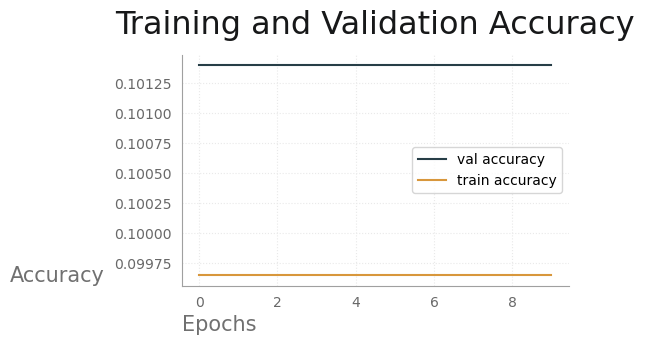

In [19]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.grid(which = 'major', axis = 'both', linestyle = ':', color = '#e9e9e9')
plt.plot(validate_log,label = 'val accuracy', color = '#273E47')
plt.plot(train_log,label = 'train accuracy', color = '#D8973C')
plt.legend(loc = 'best')
xlim = ax.get_xlim()
ax.set_xlabel('Epochs', fontsize = 15, loc =
				'left').set_color('#707070')
ax.set_ylabel('Accuracy', fontsize = 15, rotation =
				'horizontal', loc = 'bottom', labelpad =
				75).set_color('#707070')
ax.set_title('Training and Validation Accuracy', fontsize = 23, pad = 15).set_color('#171819')
for pos in ['right', 'top']:
	plt.gca().spines[pos].set_visible(False)
ax.spines['bottom'].set_color('#A0A0A0')
ax.spines['left'].set_color('#A0A0A0')
ax.tick_params(axis='y', which='both', right=False,
				left=False, colors = '#686868')
ax.tick_params(axis='x', which='both', top=False,
				bottom=False, colors = '#686868')
plt.show()